In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
(train_dataset, val_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:70%]', 'train[70%:80%]', 'train[80%:]'),
    with_info=True,
    as_supervised=True
)

In [3]:
def normalize_img(image, label):
  return (tf.cast(image, tf.float32) / 255.0, label)

def resize(image, label):
  return (tf.image.resize(image, (224, 224)), label)

In [4]:
train_dataset = train_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
#SHUFFLE_VAL = len(train_dataset) // 1000
BATCH_SIZE = 64

#train_dataset = train_dataset.shuffle(SHUFFLE_VAL)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [6]:
test_dataset = test_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [7]:
val_dataset = val_dataset.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

AlexNet

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l2
import numpy as np


AlexNet = Sequential()


AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#Passing it to a SVM
AlexNet.add(Flatten())
AlexNet.add(Dense(512, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(1, kernel_regularizer=l2(0.01)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('linear'))
AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_12 (Ba  (None, 56, 56, 96)        384       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 256)       221440    
                                                                 
 batch_normalization_13 (Ba  (None, 28, 28, 256)      

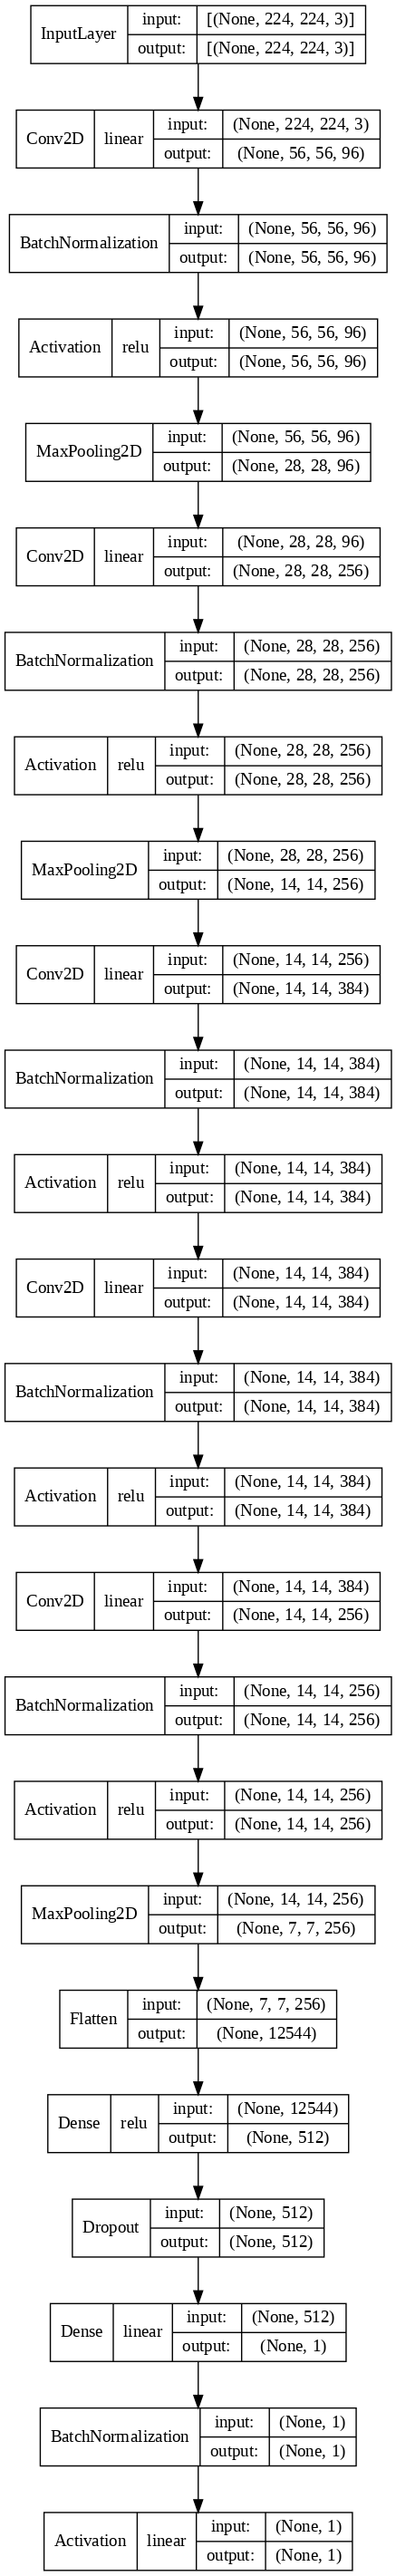

In [26]:
tf.keras.utils.plot_model(
    AlexNet,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

In [27]:
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import BinaryCrossentropy

#AlexNet.compile(loss=BinaryCrossentropy(),
#              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

AlexNet.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import History
history = History()

es = EarlyStopping(patience=8,
                   monitor='val_accuracy')

In [29]:
AlexNet.fit(train_dataset, epochs=70, validation_data=val_dataset,
          callbacks=[es, history])

Epoch 1/70
255/255 [==============================] - 35s 119ms/step - loss: 0.9645 - accuracy: 0.5544 - val_loss: 1.0978 - val_accuracy: 0.5084
Epoch 2/70
255/255 [==============================] - 32s 125ms/step - loss: 0.8390 - accuracy: 0.6137 - val_loss: 0.9781 - val_accuracy: 0.5084
Epoch 3/70
255/255 [==============================] - 30s 119ms/step - loss: 0.7897 - accuracy: 0.6373 - val_loss: 0.7626 - val_accuracy: 0.6064
Epoch 4/70
255/255 [==============================] - 30s 115ms/step - loss: 0.7477 - accuracy: 0.6567 - val_loss: 0.7189 - val_accuracy: 0.6579
Epoch 5/70
255/255 [==============================] - 32s 124ms/step - loss: 0.7182 - accuracy: 0.6724 - val_loss: 0.7004 - val_accuracy: 0.6644
Epoch 6/70
255/255 [==============================] - 32s 124ms/step - loss: 0.6891 - accuracy: 0.6841 - val_loss: 0.6847 - val_accuracy: 0.6730
Epoch 7/70
255/255 [==============================] - 30s 116ms/step - loss: 0.6673 - accuracy: 0.7005 - val_loss: 0.6676 - val_ac

In [30]:
score = AlexNet.evaluate(test_dataset, verbose=0)
accuracy = 100*score[1]
print('Precisión durante la prueba: %.4f%%' % accuracy)

Precisión durante la prueba: 74.0542%


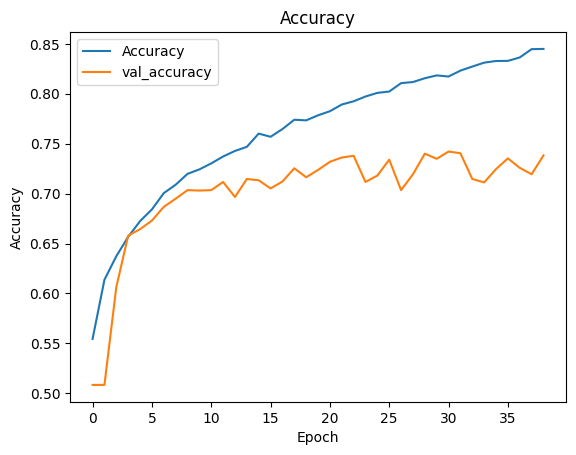

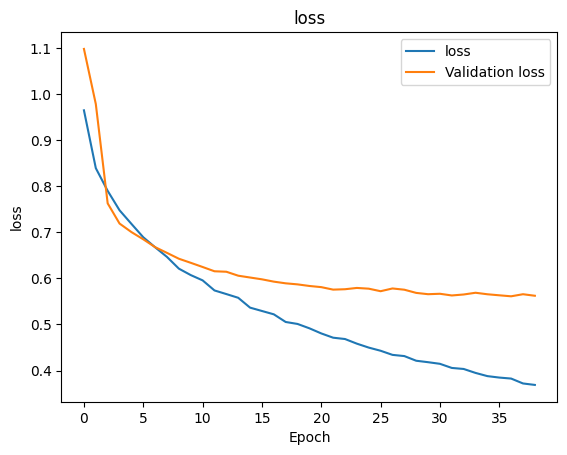

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","val_accuracy"])

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()